Cuaderno de trabajo de:
 - _Piloto_ : Nombre1 Apellido1 (username con el que os habéis logueado)
 - _Copiloto_ : Nombre2 Apellido2 [escribe el username2]

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from optlang import Model, Variable, Constraint, Objective

# El problema del viajante (traveling salesman)

[https://es.wikipedia.org/wiki/Problema_del_viajante](https://es.wikipedia.org/wiki/Problema_del_viajante)

> El problema del vendedor viajero, problema del vendedor ambulante, problema del agente viajero o problema del viajante (TSP por sus siglas en inglés (Travelling Salesman Problem)), responde a la siguiente pregunta: dada una lista de ciudades y las distancias entre cada par de ellas, ¿cuál es la ruta más corta posible que visita cada ciudad exactamente una vez y al finalizar regresa a la ciudad origen? Este es un problema NP-Hard dentro en la optimización combinatoria, muy importante en la investigación de operaciones y en la ciencia de la computación. 

Vamos a plantear este problema usando MILP. Comenzamos por una lista de ciudades, con latitud y longitud arbitrarias, y asumimos que la distancia entre cada par de ciudades es la distancia euclídea en el plano entre cada par de ciudades.

In [46]:
COORDENADAS = np.array([
    [-0.0000000400893815,0.0000000358808126],
    [-43.0700258454450875,-14.5548396888330487],
    [-50.4808382862985496,-7.3744722432402208],
    [-14.6577381710829471,43.3895496964974043],
    [-64.7472605264735108,-21.8981713360336698],
    [-72.0785319657452987,-0.1815834632498404],
    [-79.2915791686897506,21.4033307581457670],
    [-65.0865638413727368,36.0624693073746769],
    [-36.0366489745023770,21.6135482886620949],
    [-29.0584693142401171,43.2167287683090606],
    [-21.4983260706612533,-7.3194159498090388],
    [-28.8732862244731230,-0.0000008724121069],
    [-57.5687244704708050,43.2505562436354225],
    [-50.5859026832315024,21.5881966132975371],
    [-0.1358203773809326,28.7292896751977480]
])
N, _ = COORDENADAS.shape

Dibujamos las ciudades

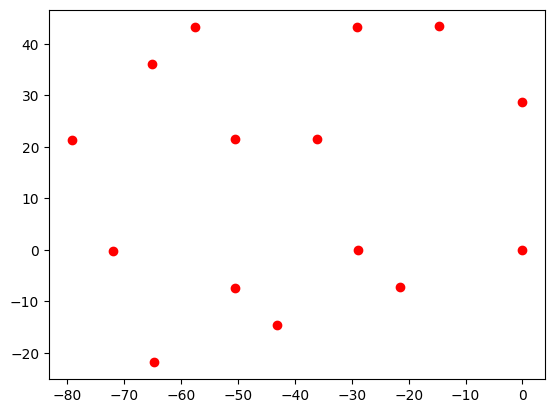

In [47]:
plt.plot(COORDENADAS[:,0], COORDENADAS[:,1], 'ro')

Si las unimos de cualquier manera, por ejemplo en el orden en que venían, no obtenemos la ruta más corta

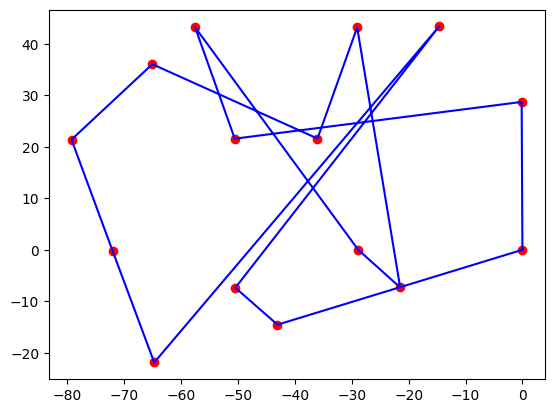

In [48]:
# Dibujamos los puntos
plt.plot(COORDENADAS[:,0], COORDENADAS[:,1], 'ro')
# Cerramos el camino volviendo al punto de partida
plt.plot(np.concatenate([COORDENADAS[:,0], COORDENADAS[:1,0]]),
         np.concatenate([COORDENADAS[:,1], COORDENADAS[:1,1]]), 'b')

Comenzamos por crear una matriz con la distancia euclídea entre cada par de ciudades

In [49]:
import math
def d(p1,p2):
    x1, y1 = p1
    x2, y2 = p2
    return math.sqrt((x1-x2)**2 + (y1-y2)**2)

def matriz_distancias(coordenadas):
    N, _ = coordenadas.shape

    return np.array([
        [d(coordenadas[j], coordenadas[k]) for j in range(N) ]
        for k in range(N)
    ])

DISTANCIAS = matriz_distancias(COORDENADAS)

In [50]:
DISTANCIAS

array([[ 0.        , 45.46284727, 51.01664308, 45.79849678, 68.35011083,
        72.07876065, 82.1295141 , 74.40942465, 42.02125099, 52.07763703,
        22.71017112, 28.87328618, 72.00533761, 54.99985252, 28.72961069],
       [45.46284727,  0.        , 10.31880893, 64.53534188, 22.88726771,
        32.37412426, 51.03911193, 55.19818761, 36.84590451, 59.44642831,
        22.75279297, 20.33201291, 59.59593997, 36.91622242, 60.96607133],
       [51.01664308, 10.31880893,  0.        , 62.13115503, 20.35850286,
        22.76396322, 40.72125656, 45.82679468, 32.38734227, 54.93985359,
        28.98256451, 22.83131915, 51.11879928, 28.96285942, 61.95242088],
       [45.79849678, 64.53534188, 62.13115503,  0.        , 82.28880098,
        72.08044953, 68.27098377, 50.95834147, 30.51642286, 14.4017681 ,
        51.16827962, 45.65889733, 42.91121141, 42.02537331, 20.63514769],
       [68.35011083, 22.88726771, 20.35850286, 82.28880098,  0.        ,
        22.92068345, 45.67884946, 57.96163378, 

Una forma habitual un valor para cada par de índices es mediante un _heatmap_.
En este caso, el valor es la distancia y el par de índices son las dos ciudades

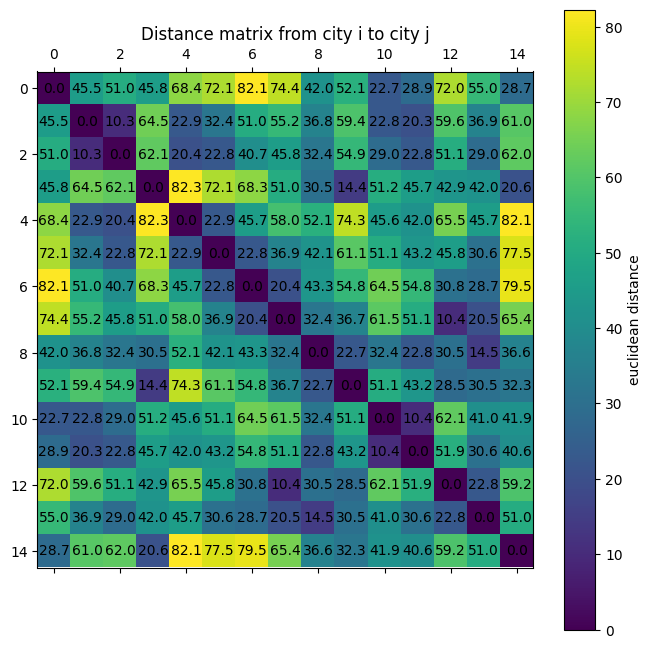

In [51]:
# Una forma de visualizar las distancias
def heatmap(array_distancias, labels=None):
    plt.figure(figsize=(8,8))
    im = plt.matshow(array_distancias, fignum=1)
    N, _ = array_distancias.shape
    for i in range(N):
        for j in range(N):
            plt.text(i,j,'%00.1f'%array_distancias[i,j], ha='center', va='center')
    cbar = plt.colorbar(im)
    cbar.set_label('euclidean distance')
    plt.title('Distance matrix from city i to city j')
    if labels is not None:
        for f in (plt.xticks, plt.yticks):
            f(ticks=np.arange(N),labels=labels)

heatmap(DISTANCIAS)

Intentamos el siguiente planteamiento:

#### Variables

La variable ``c_3,4`` vale 1 si, cuando sale de la ciudad 3, el viajante va a la ciudad 4.

#### Restricciones

- ``c_4,0 + c_4,1 + c_4,2 + ... + c_4,N`` tiene que ser 1, porque cuando salga de la ciudad 4, no puede ir a dos ciudades distintas.
- ``c_0,4 + c_1,4 + ... + c_N,4`` tiene que ser 1, porque sólo puede llegar a la ciudad 4 una vez.

In [52]:
def VIAJANTE_v1(distancias, timeout=5):
    N,_ = distancias.shape
    model = Model(name='Viajante')

    c = [[Variable('c_%d,%d'%(i,j), type='binary')
          for i in range(N)]
          for j in range(N)
         ]
    constraints = []
    for i in range(N):
        #Solo se puede salir de la ciudad i una vez
        constraints.append(Constraint(sum(c[i][j] for j in range(N) if j!=i), ub=1, lb=1))
        #Solo se puede entrar en la ciudad i una vez
        constraints.append(Constraint(sum(c[j][i] for j in range(N) if j!=i), ub=1, lb=1))

    obj = Objective(sum(c[j][k]*distancias[j,k] for j in range(N) for k in range(N) if j!= k), 
                    direction='min')
    model.objective = obj
    model.configuration.timeout=timeout
    model.add(constraints)
    return c, model

In [53]:
%%time
c, model = VIAJANTE_v1(DISTANCIAS, timeout=1)
model.optimize()
print(model.status)

optimal
CPU times: user 637 ms, sys: 0 ns, total: 637 ms
Wall time: 635 ms


In [54]:
def plot_path(variables, coordenadas, labels=None):
    plt.figure()
    plt.plot(coordenadas[:,0], coordenadas[:,1], 'ro')
    npoints, _ = coordenadas.shape
    if labels is None:
        labels = range(npoints)
    for j in range(npoints):
        plt.text(coordenadas[j,0], coordenadas[j,1], labels[j])
    for var_name, var in variables.iteritems():
        if var_name.count(',')!=1:
            continue
        si,sj = var_name[2:].split(',')
        i, j = int(si), int(sj)
        if var.primal>0:
            plt.plot([coordenadas[i,0], coordenadas[j,0]],
                     [coordenadas[i,1], coordenadas[j,1]], 'b')


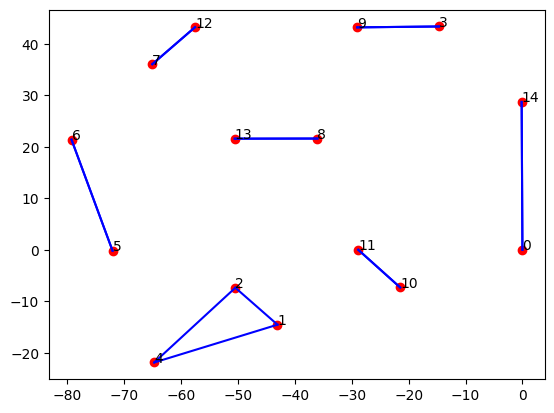

In [55]:
plot_path(model.variables, COORDENADAS)

### ¿Qué ha ocurrido?

La solución cumple las restricciones: de cada ciudad entra una vez, y sale una vez, pero ahora nos damos cuenta de que no es suficiente. El camino no es **conexo**, y no es lo que queríamos.

Intentamos resolverlo añadiendo más restricciones:

 - para cada par de ciudades (i,j), sólo puede haber una de las dos variables, o la c_ij, o la c_ji, pero no ambas (también permitimos que ambas sean 0, claro, para que ese trayecto pueda no formar parte del camino final).

In [56]:
for i in range(N):
    for j in range(N):
        model.add(Constraint(c[i][j] + c[j][i], ub=1))
model.optimize()
model.status

'optimal'

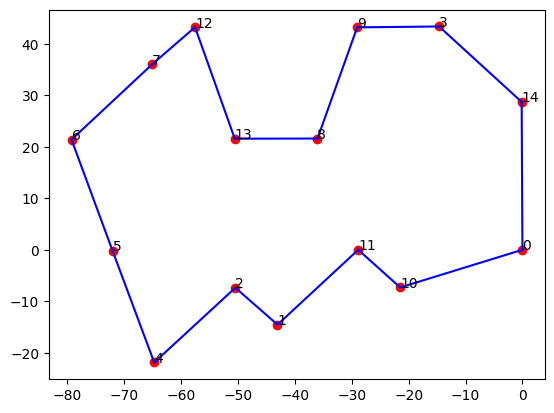

In [57]:
plot_path(model.variables, COORDENADAS)

### Ejercicio 1

Escribe una versión 2 del problema anterior, que directamente incluye las restricciones de que no se puede ir y volver por el mismo camino. Comprueba que de la solución correcta para el problema anterior

In [58]:
def VIAJANTE_v2(distancias):
    #TODO
    pass

### Ejercicio 2

¿Funciona la versión anterior con esta nueva lista de ciudades?

In [59]:
COORDENADAS2 = np.array([
    [0,0],
    [1,0],
    [1,1],
    [10,10],
    [10,12],
    [12,10]
])

DISTANCIAS2 = matriz_distancias(COORDENADAS2)
N2, _ = COORDENADAS2.shape

Hay varias formas de resolver el problema del camino no conexo:

 - Podemos intentar seguir añadiendo restricciones del tipo c_12 + c_23 + c_31<=2, que impide que las tres variables sean 1 a la vez, lo que correspondería a un camino cerrado. Es un enfoque popular, pero las restricciones no se añaden a priori, sino sobre la marcha, cada vez que una solución no corresponde a un camino conexo. Añadir todas esas restricciones antes de empezar es prohibitivo, porque la cantidad de tales restricciones crece de forma exponencial en el número de ciudades. _No seguiremos este enfoque_.

 - Podemos usar la siguiente solución [Miller-Tucker-Zemlin formulation en la wikipedia](https://en.wikipedia.org/wiki/Travelling_salesman_problem#Integer_linear_programming_formulations)

### Ejercicio 3

La formulación de Miller-Tucker-Zemlin consiste en:

 - Añadir variables adicionales $u_j$, enteras, que representan la posición que ocupa cada ciudad en el camino final. La primera ciudad no tiene variable.
 - Añadir restricciones adicionales.
 
La siguiente versión del código intenta implementar esta formulación. Ya se han añadido las variables $u_i$, pero falta añadir las restricciones:

$$
u_i - u_j + (N-1)\cdot c_{ij} \leq N-2
$$

_sólo para $i\neq j$, y sólo desde $i=1$ hasta $i=N-1$ y desde $j=1$ hasta $j=N-1$:_


 - Termina el trabajo y comprueba la solución en el ejemplo anterior.

In [60]:
def VIAJANTE_v3(distancias, timeout=1):
    N,_ = distancias.shape
    model = Model(name='Viajante')

    c = [[Variable('c_%d,%d'%(i,j), type='binary')
          for i in range(N)]
          for j in range(N)
         ]
    #Añadimos las variables u de la formulación de Miller-Tucker-Zemlin
    u = [Variable('u(%d)'%i, type='integer') for i in range(N)]

    constraints = []
    for i in range(N):
        #Solo se puede salir de la ciudad i una vez
        constraints.append(Constraint(sum(c[i][j] for j in range(N) if j!=i), ub=1, lb=1))
        #Solo se puede entrar en la ciudad i una vez
        constraints.append(Constraint(sum(c[j][i] for j in range(N) if j!=i), ub=1, lb=1))

    #¡¡¡¡ TODO !!!!
    #Añade aquí las restricciones u_i - u_j + N c_ij <= N-1

    model.add(constraints)
        
    obj = Objective(sum(c[j][k]*distancias[j,k] for j in range(N) for k in range(N) if j!= k), 
                    direction='min')
    model.objective = obj
    model.configuration.timeout = timeout

    return c, model

In [61]:
%%time

# La solución será incorrecta hasta que no incorpores las nuevas restricciones!

c, model = VIAJANTE_v3(DISTANCIAS2)
model.optimize()
print(model.status)
plot_path(model.variables, COORDENADAS2)

optimal
CPU times: user 78.7 ms, sys: 7.34 ms, total: 86 ms
Wall time: 83 ms


optimal
CPU times: user 652 ms, sys: 8.8 ms, total: 660 ms
Wall time: 656 ms


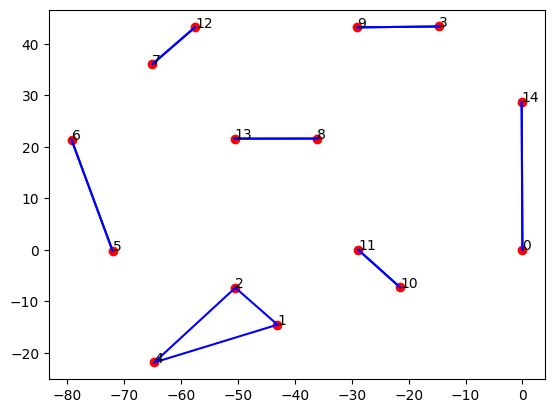

In [62]:
%%time

# La solución será incorrecta hasta que no incorpores las nuevas restricciones!

c, model = VIAJANTE_v3(DISTANCIAS)
model.optimize()
print(model.status)
plot_path(model.variables, COORDENADAS)

In [ ]:
%%time

# La solución será incorrecta hasta que no incorpores las nuevas restricciones!

c, model = VIAJANTE_v3(DISTANCIAS)
model.optimize()
print(model.status)
plot_path(model.variables, COORDENADAS)

optimal
CPU times: user 752 ms, sys: 5.68 ms, total: 757 ms
Wall time: 754 ms


### Ejercicio 4

En el ejercicio anterior, imprime el valor de cada variable $u_j$ en el resultado final, y comprueba que corresponden a la posición que ocupa cada ciudad en el camino final. Recuerda que:
 - la primera ciudad no tiene variable
 - `model.variables` es un iterable con todas las variables de decisión del problema
 - Para una variable `v`, `v.primal` es el valor de la variable después de haber encontrado el valor óptimo.



## Ciudades españolas

Aplicamos ahora el problema al problema de recorrer las ciudades españolas, usando datos reales de distancias por carretera.

Comenzamos por cargar los datos de las distancias entre capitales españolas usando la librería `pandas`, una librería muy popular de tratamiento de datos.

In [30]:
import pandas as pd
distancias = pd.read_csv('distancia-entre-ciudades.csv', index_col=0)
distancias

Albacete  Alicante  Almería  Ávila  Badajoz  Barcelona  Bilbao  \
Albacete            0       171      369    366      525        540     646   
Alicante          171         0      294    537      696        515     817   
Almería           369       294        0    663      604        809     958   
Ávila             366       537      663      0      318        717     401   
Badajoz           525       696      604    318        0       1022     694   
Barcelona         540       515      809    717     1022          0     620   
Bilbao            646       817      958    401      694        620       0   
Burgos            488       659      800    243      536        583     158   
Cáceres           504       675      651    229       89        918     605   
Cádiz             617       688      484    618      342       1284    1058   
Castellón         256       231      525    532      805        284     607   
Ciudad Real       207       378      407    256      318        811     585   
Córdoba           354       525      332    457      272        908     795   
A Coruña          860      1031     1172    538      772       1118     644   
Cuenca            142       313      511    282      555        562     562   
Gerona            640       615      909    817     1122        100     720   
Granada           363       353      166    534      438        868     829   
Guadalajara       309       480      621    173      459        563     396   
Huelva            506       703      516    552      251       1140     939   
Huesca            495       570      830    490      798        274     322   
Jaén              264       415      228    435      376        804     730   
León              584       855      896    255      496        784     359   
Lérida            515       490      802    558      866        156     464   
Logroño           578       653      899    358      676        468     152   
Lugo              762       933     1074    440      674       1020     546   
Madrid            251       422      563    115      401        621     395   
Málaga            473       482      219    644      436        997     939   
Murcia            150        75      219    516      675        590     796   
Orense            772       943     1084    443      645       1027     605   
Oviedo            702       873     1014    373      614        902     304   
Palencia          491       662      803    168      461        669     244   
Pamplona          598       673      970    437      755        437     159   
Pontevedra        874      1045     1186    545      747       1129     707   
Salamanca         463       634      763     97      299        778     395   
S.Sebastián       691       766     1032    475      768        529     119   
Santander         644       815      956    369      662        693     108   
Segovia           338       509      650     67      385        650     355   
Sevilla           492       609      422    493      217       1046     993   
Soria             473       548      794    261      579        453     257   
Tarragona         443       417      711    649      935         98     555   
Teruel            242       317      577    417      703        409     488   
Toledo            240       411      526    137      368        692     466   
Valencia          191       166      460    467      716        349     633   
Valladolid        444       615      756    121      414        663     280   
Vitoria           602       739      914    357      650        530      66   
Zamora            499       670      811    159      361        759     376   
Zaragoza          423       498      758    418      726        296     324   

             Burgos  Cáceres  Cádiz  ...  Sevilla  Soria  Tarragona  Teruel  \
Albacete        488      504    617  ...      492    473        443     242   
Alicante        659      675    688  ...      609    548      

En la chuleta de Estadística tenéis algunos comandos para manejo de datos con pandas. Hoy nos bastará con `distancias.loc['Albacete','Vitoria']` para tener la distancia de Albacete a Vitoria.

In [31]:
distancias['Albacete']['Vitoria']

602

In [32]:
distancias.loc['Albacete','Vitoria']

602

In [33]:
distancias.loc['Albacete','Alicante']

171

In [34]:
NCIUDADES = 6
DISTANCIAS_CIUDADES = distancias.values[:NCIUDADES, :NCIUDADES ]
NOMBRES_CIUDADES = distancias.index[:NCIUDADES]

# Una forma de visualizar las distancias
plt.figure(figsize=(8,8))
heatmap(DISTANCIAS_CIUDADES, labels=NOMBRES_CIUDADES)

<Figure size 800x800 with 0 Axes>

Cargamos también otro dataset donde vienen latitud y longitud de cada ciudad. No es necesario para plantear ni resover el problema, pero es útil para dibujar el resultado...

In [35]:
latlon = pd.read_csv('latitud_longitud.csv', index_col=0, decimal=',')
NOMBRES_CIUDADES = distancias.index[:NCIUDADES]
[latlon.loc[ciudad, 'Lat'] for ciudad in NOMBRES_CIUDADES]

[38.99588053, 38.34548705, 36.83892362, 40.65586958, 38.87874339, 41.38424664]

In [36]:
latlon.loc[NOMBRES_CIUDADES, ['Lat', 'Lon']]

Lat       Lon
Albacete   38.995881 -1.855747
Alicante   38.345487 -0.483183
Almería    36.838924 -2.464132
Ávila      40.655870 -4.697713
Badajoz    38.878743 -6.970997
Barcelona  41.384247  2.176349

In [37]:
COORDENADAS2.shape

(6, 2)

Resolvemos el problema MILP del viajante para unas cuantas ciudades, para no reventar el ordenador. Puedes probar con más ciudades, pero:

 - Prepárate para usar "Restart kernel" si se queda tostado...
 - Al evaluar la solución obtenida, puede que se alcance `model.status=time_limit`, en cuyo caso la solución obtenida no es óptima! 

optimal
CPU times: user 758 ms, sys: 0 ns, total: 758 ms
Wall time: 754 ms


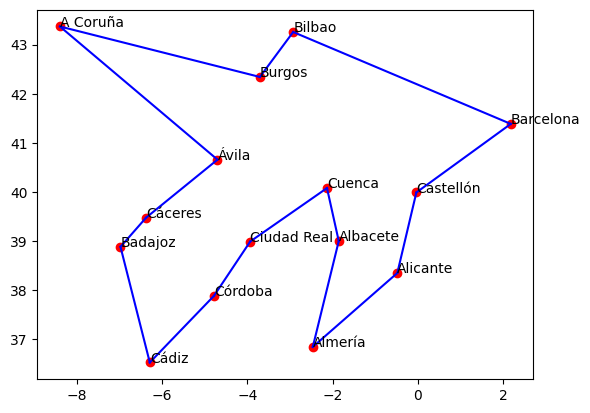

In [69]:
%%time
NCIUDADES = 15
DISTANCIAS_CIUDADES = distancias.values[:NCIUDADES, :NCIUDADES ]
NOMBRES_CIUDADES = distancias.index[:NCIUDADES]
COORDS_CIUDADES = latlon.loc[NOMBRES_CIUDADES, ['Lon', 'Lat']].values

# La solución será incorrecta hasta que no incorpores las nuevas restricciones!

c, model = VIAJANTE_v3(DISTANCIAS_CIUDADES, timeout=2)
model.optimize()
print(model.status)
plot_path(model.variables, COORDS_CIUDADES, labels=NOMBRES_CIUDADES)

Imprimimos las variables `u` para ver el orden en que se recorren las ciudades.

In [70]:
for v in model.variables:
    if v.name.startswith('u'):
        i = int(v.name[2:-1])
        print(v, ',', NOMBRES_CIUDADES[i], ':', v.primal)

u(1) , Alicante : -5.0
u(2) , Almería : -6.0
u(3) , Ávila : 1.0
u(4) , Badajoz : 3.0
u(5) , Barcelona : -3.0
u(6) , Bilbao : -2.0
u(7) , Burgos : -1.0
u(8) , Cáceres : 2.0
u(9) , Cádiz : 4.0
u(10) , Castellón : -4.0
u(11) , Ciudad Real : 6.0
u(12) , Córdoba : 5.0
u(13) , A Coruña : 0.0
u(14) , Cuenca : 7.0
